# Project 3 - Solving PDEs using Physics Informed Neural Networks (PINNs)
## Exploring PINN-implementations and their performance
This notebook is the main one for my project. In it, I go through two different PINN-implementations, one following the approach from ([Ch.15, FYS-STK3155/4155](https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter11.html)), and one following the approach from ([M. Raissi et.al.](https://maziarraissi.github.io/PINNs/)), and compare their performance when solving PDEs to solutions from finite difference methods (FDMs).

The equations are the unsteady wave equation and the diffusion equation, first on a one-dimensional spatial domain, and secondly in two spatial dimensions. 

The equations are, for $u = u(t,\boldsymbol{x})$:
### Diffusion equation
$$\frac{\partial u}{\partial t} - D\nabla^{2}u = f(t,\boldsymbol{x}) $$
with $D$ as the diffusion coefficient, and $f(t,\boldsymbol{x})$ as a generic source function. 

### Wave equation
$$\frac{\partial^{2} u}{\partial t^{2}} - c^{2}\nabla^{2}u = f(t,\boldsymbol{x}) $$
with $c$ denoting the wave speed.

In the end of the notebook, I am also attempting to show one of the advantages of using PINNs to solve PDE, namely the ability to extraploate outside the initial time domain, using the trained model. 

### Notebook imports and defaults

In [2]:
from network import *
from networkFlowTorch import *
from FiniteDiff import *
from PDEq import *
from support import *

from time import time

import autograd.numpy as anp
import numpy as np

import matplotlib.pyplot as plt

from autograd import elementwise_grad
from sklearn.metrics import r2_score

## Random seed
default_seed = 15; anp.random.seed(default_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (5,5); plt.rcParams["font.size"] = 10

## One-dimensional PDEs
### Problem setup

In [ ]:
## Differential equations
test_cases = ['diff1d','wave1d']
test = test_cases[1]

## Coefficients
c,D,amplitude = 1.,1.,1.

## Setup for PINNs
if test == 'diff1d':
    PDE = Diffusion1D(sim_type='own',amp=amplitude,D=D)
    PDE_tf = Diffusion1D(sim_type='flow',amp=amplitude,D=D)
    t0,tN,x0,xN = 0,1,0,1
elif test == 'wave1d':
    PDE = Wave1D(sim_type='own',amp=amplitude,c=c)
    PDE_tf = Wave1D(sim_type='flow',amp=amplitude,c=c)
    t0,tN,x0,xN = 0,1,-1,1

## Domain setup
Nt,Nx = 20,20

## Defining the source function
f = PDE.right_hand_side
f_tf = PDE_tf.right_hand_side

t_bound = [t0,tN]
x_bound = [x0,xN]

t = np.linspace(t_bound[0],t_bound[1],Nt)
x = np.linspace(x_bound[0],x_bound[1],Nx)

domain_array = np.array([t,x])

## Setup for FD-solver
x_s,t_s = sp.symbols('x, t')
## Simulation and equation coefficients
cfl = 0.1
if test == 'diff1d':
    x_bound = [x0,xN]
    bc = {'left': 0, 'right': 0}
    L = x_bound[1] + np.abs(x_bound[0])
    u0 = amplitude * sp.sin(sp.pi*x_s/L)
    fd_solver = Diffusion1DSolver(N=Nx,domain=x_bound,cfl=cfl,u0=u0,D=D)
    
elif test == 'wave1d':
    x_bound = [x0,xN]
    bc = {'left': 0, 'right': 0}
    L = x_bound[1] + np.abs(x_bound[0])
    u0 = amplitude * sp.sin(sp.pi*x_s/L)
    fd_solver = Wave1DSolver(N=Nx,domain=x_bound,cfl=cfl,u0=u0,amp=amplitude,c=c)

### Network setup

In [5]:
## Layer configuration
#layer_out_sizes = [20,20,20,20,20,20,1]
layer_out_sizes = [20,20,20,1]

## Activation functions
hidden_func_tf = 'tanh' # sigmoid, relu, elu, leaky_relu, tanh, swish, gelu, hard_sigmoid, exponential
hidden_func = tanh
hidden_der = elementwise_grad(hidden_func,0)

act_funcs_tf = []; act_funcs = []; act_ders = []
for i in range(len(layer_out_sizes)-1):
    act_funcs_tf.append(hidden_func_tf)
    act_funcs.append(hidden_func)
    act_ders.append(hidden_der)

## Output layer activation function set to identity
act_funcs_tf.append(None); 

act_funcs.append(identity); 
output_der = identity #elementwise_grad(act_funcs[-1],0);
act_ders.append(output_der)

# TensorFlow-implementation
## Gradient descent method, regularizer and learning rate
lmbda_tf = 1e-8
gd_method_tf = 'adam'
eta_tf = 1e-2 # None
tf_epoch = 1000

## Collocation tensor parameters
c_points = 100; b_points = 10; i_points = 10

## Network initializtion
TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs_tf,
                           PDE=PDE_tf,
                           source_function=f_tf,
                           domain_array=domain_array,
                           domain=x_bound,
                           gd_method=gd_method_tf,
                           learning_rate=eta_tf)

## Setup of collocation tensor
TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
TFNetwork.create_layers(lmbda=lmbda_tf)

# Autograd-implementation
## Gradient descent method, regularizer and learning rate
eta = [eta_tf if eta_tf is not None else 1e-2]
lmbda = lmbda_tf
epoch = tf_epoch #100
gd_method = ADAM(learning_rate=eta,lmbda=lmbda)

## Network initializtion
OwnNetwork = FFNNetwork(layer_output_size=layer_out_sizes,
                        activation_functions=act_funcs,
                        activation_derivatives=act_ders,
                        PDE=PDE,
                        source_function=f,
                        domain_array=domain_array,
                        domain=x_bound,
                        random_state=default_seed)

### Network training

In [ ]:
epoch = epoch
tf_epoch = tf_epoch

own_net_timer = [time()]
P = OwnNetwork.train_network(GDMethod=gd_method,epochs=epoch)
own_net_timer.append(time())


tf_net_timer = [time()]
TFNetwork.train_network(epochs=tf_epoch)
tf_net_timer.append(time())

print('Plain PINN-solver time     : %.2f sec.' %(own_net_timer[1]-own_net_timer[0]))
print('TensorFlow PINN-solver time: %.2f sec.' %(tf_net_timer[1]-tf_net_timer[0]))

### Finite difference solver

In [ ]:
fd_timer = [time()]

fd_solver.solver(tN=t_bound[1],cfl=cfl,bc=bc,ic=0)

fd_timer.append(time())

print('FD-solver time: %.2f sec.' %(fd_timer[1]-fd_timer[0]))

### Comparison between methods

In [ ]:
times = [0.1,0.5,0.9]; plots = 'slices'
OwnNetwork.plot_result(plots=plots,time=times)
TFNetwork.plot_results(plots=plots,time=times)
fd_solver.plot_result(tN=tN,plots=plots,time=times)

print('Autograd solution:')
print('Mean difference, Own: %.5f' %OwnNetwork.abs_diff.mean())
print('Max difference: %.5f' %OwnNetwork.abs_diff.max())
print('Min difference: %.5f\n' %OwnNetwork.abs_diff.min())
print('TensorFlow solution:')
print('Mean difference, TF: %.5f' %TFNetwork.abs_diff.mean())
print('Max difference: %.5f' %TFNetwork.abs_diff.max())
print('Min difference: %.5f\n' %TFNetwork.abs_diff.min())
print('Finite difference solution')
print('Mean difference, FD: %.5f' %fd_solver.abs_diff.mean())
print('Max difference: %.5f' %fd_solver.abs_diff.max())
print('Min difference: %.5f' %fd_solver.abs_diff.min())


## Two-dimensional PDEs
### Problem setup

In [8]:
## Differential equations
test_cases = ['wave2d','diff2d']
test = test_cases[1]

## Coefficients
c,D,amplitude = 1.,1.,1.
## Domain setup
Nt,Nx,Ny = 100,100,100

## Setup for PINN
if test == 'wave2d':
    PDE = Wave2D(sim_type='flow',amp=amplitude,c=c)
    t0,tN = 0,1
    x0,xN,y0,yN = 0,1,0,1
elif test == 'diff2d':
    PDE = Diffusion2D(sim_type='flow',amp=amplitude,D=D)
    t0,tN = 0,1
    x0,xN,y0,yN = 0,1,0,1

t_bound = [t0,tN]
x_bound = [x0,xN]
y_bound = [y0,yN]

t = np.linspace(t_bound[0],t_bound[1],Nt)
x = np.linspace(x_bound[0],x_bound[1],Nx)
y = np.linspace(y_bound[0],y_bound[1],Ny)

domain_array = np.array([t,x,y])

## Setup for FD-solver
## Simulation and equation coefficients
cfl = 0.1
if test == 'wave2d':
    bc = {'x0': 0, 'xN': 0, 'y0': 0, 'yN': 0}
    fd_solver = Wave2DSolver(N=Nx,domain=(x_bound,y_bound),cfl=cfl,
                             amp=amplitude,c=c,m=[1,1])
elif test == 'diff2d':
    bc = {'x0': 0, 'xN': 0, 'y0': 0, 'yN': 0}
    N = 20
    fd_solver = Diffusion2DSolver(N=N,domain=(x_bound,y_bound),cfl=cfl,
                                  amp=amplitude,D=D)
    
## Defining the source function (necessary?)
f = PDE.right_hand_side

### Network setup

In [9]:
## Layer configuration
#layer_out_sizes = [20,20,20,20,20,20,20,20,1]
layer_out_sizes = [20,20,1]

## Activation functions
hidden_func = 'swish' # sigmoid, relu, elu, leaky_relu, tanh, swish, gelu, hard_sigmoid, exponential

act_funcs = []
for i in range(len(layer_out_sizes)-1):
    act_funcs.append(hidden_func)

## Output layer activation function set to identity
act_funcs.append(None); 

## Gradient descent method, regularizer and learning rate
gd_method = 'adam'
epoch = 3000
eta = 5e-2
lmbda = 1e-8

## Collocation tensor parameters
c_points = 5000; b_points = 50; i_points = 50

TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

## Setup of collocation tensor
TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)

TFNetwork.create_layers(lmbda=lmbda)

### Network training

In [10]:
tf_net_timer = [time()]

TFNetwork.train_network(epochs=epoch,tol=1e-10)

tf_net_timer.append(time())

Final cost = 1.68947e-03


### Finite differences solver

In [11]:
fd_timer = [time()]

fd_solver.solver(tN=tN,bc=bc)

fd_timer.append(time())

### Comparison

TensorFlow solution:
Mean difference, TF: 0.06287
Max difference: 0.36324
Min difference: 0.00000

Finite difference solution
Mean difference, FD: 0.21433
Max difference: 0.81171
Min difference: 0.00000


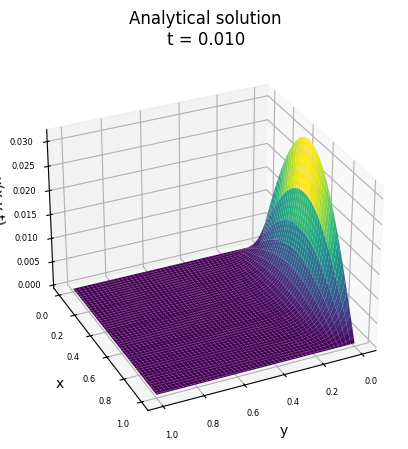

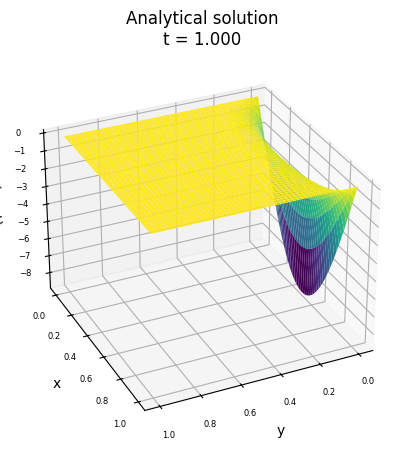

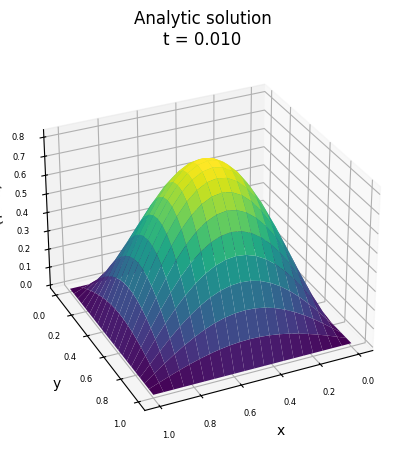

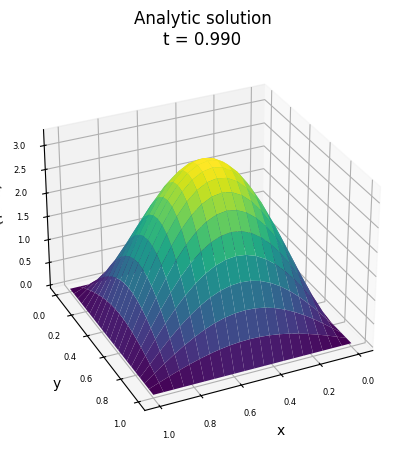

In [13]:
times = [0.01,0.99]; plots = 'exact'
TFNetwork.plot_results(plots=plots,time=times)
fd_solver.plot_result(plots=plots,time=times)

print('TensorFlow solution:')
print('Mean difference, TF: %.5f' %TFNetwork.abs_diff.mean())
print('Max difference: %.5f' %TFNetwork.abs_diff.max())
print('Min difference: %.5f\n' %TFNetwork.abs_diff.min())
print('Finite difference solution')
print('Mean difference, FD: %.5f' %fd_solver.abs_diff.mean())
print('Max difference: %.5f' %fd_solver.abs_diff.max())
print('Min difference: %.5f' %fd_solver.abs_diff.min())

## Reusing trained network
### Network setup

In [34]:
## Layer configuration
#layer_out_sizes = [20,20,20,20,20,20,20,20,1]
layer_out_sizes = [20,20,1]

## Activation functions
hidden_func = 'gelu' # sigmoid, relu, elu, leaky_relu, tanh, swish, gelu, hard_sigmoid, exponential

act_funcs = []
for i in range(len(layer_out_sizes)-1):
    act_funcs.append(hidden_func)

## Output layer activation function set to identity
act_funcs.append(None); 

## Gradient descent method, regularizer and learning rate
gd_method = 'adam'
epoch = 3000
eta = 1e-2
lmbda = 1e-8

## Collocation tensor parameters
c_points = 5000; b_points = 100; i_points = 100

TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

## Setup of collocation tensor
TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)

TFNetwork.create_layers(lmbda=lmbda)

### Network training

In [35]:
tf_net_timer = [time()]

TFNetwork.train_network(epochs=epoch)

tf_net_timer.append(time())

Final cost = 1.40275e-03


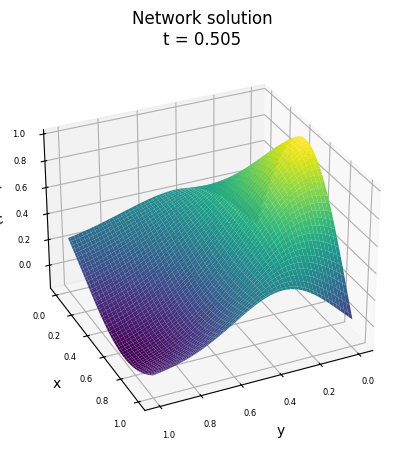

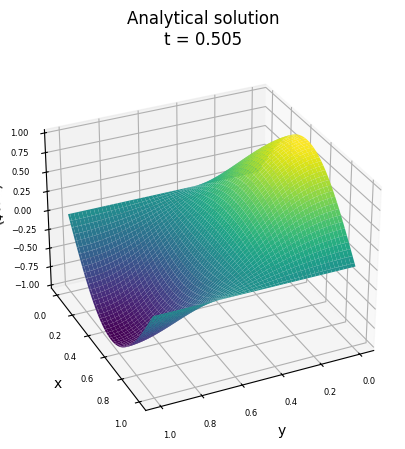

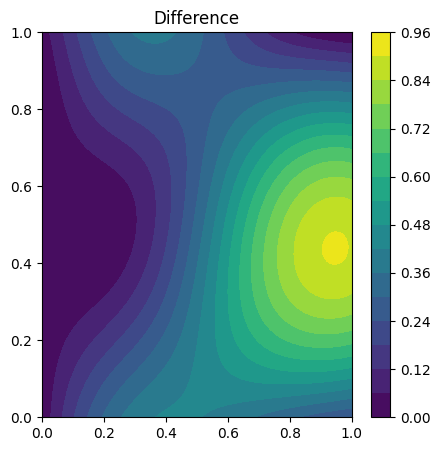

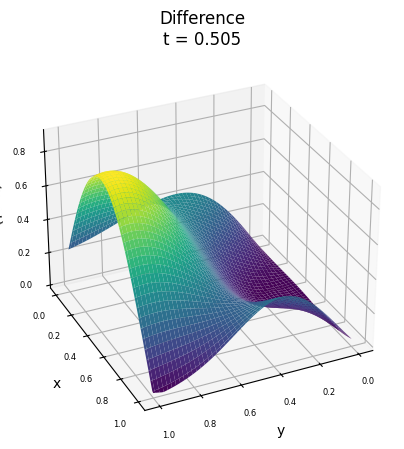

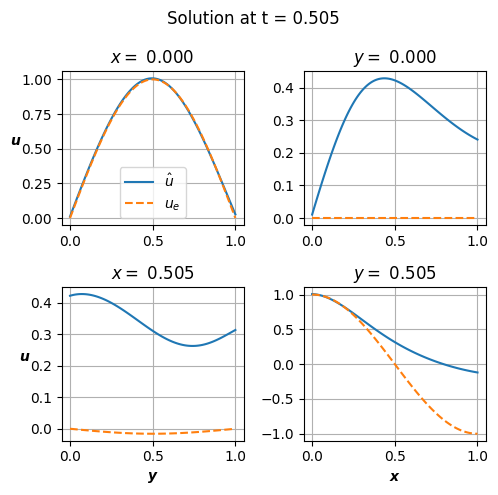

In [36]:
TFNetwork.plot_results(plots='all',time=[0.5])

### New domain

In [39]:
## New time domain
tMax = 2.
t_bound = [tN,tMax]
t = np.linspace(t_bound[0],t_bound[1],Nt)
domain_array = np.array([t,x,y])

tt,xx,yy = np.meshgrid(t,x,y,indexing='ij')
xgrid = np.vstack((tt.flatten(),xx.flatten(),yy.flatten())).T

### Prediction of extrapolated domain

(<Figure size 500x500 with 1 Axes>, <Axes3D: >)

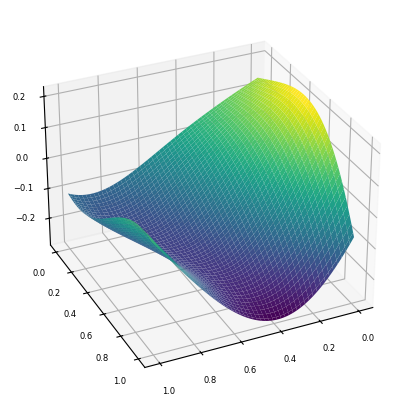

In [40]:
newsol = TFNetwork.model(tf.cast(xgrid,tf.float32))
sol = newsol.numpy().reshape(tt.shape)

plot2D(xx[10,:,:],yy[10,:,:],sol[10,:,:])